# Ejemplo cesta de la compra
>Supóngase que se dispone del registro de todas las compras que se han realizado en un supermercado. El objetivo del análisis es identificar productos que tiendan a comprarse de forma conjunta para así poder situarlos en posiciones cercanas dentro de la tienda y maximizar la probabilidad de que los clientes compren.

In [1]:
# Librerías
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules

In [ ]:
RUTA_GLOBAL = './Data/'

## Datos
Para este ejemplo se emplea el set de datos **Comestibles** del paquete de R arules, que contiene un registro de todas las ventas realizadas por un supermercado durante 30 días. En total se dispone de 9835 transacciones formadas por combinaciones de 169 productos.

In [3]:
# Datos
# ==============================================================================
datos = pd.read_csv(f'{RUTA_GLOBAL}/comestibles.csv', sep= ';')
datos.head(10)

,id_compra,item
0,1,citrus fruit
1,1,semi-finished bread
2,1,margarine
3,1,ready soups
4,2,tropical fruit
5,2,yogurt
6,2,coffee
7,3,whole milk
8,4,pip fruit
9,4,yogurt


## Exploración de transacciones e ítems
Uno de los primeros análisis que conviene realizar cuando se trabaja con transacciones es explorar su contenido y tamaño, es decir, el número de ítems que las forman y cuáles son.

En este conjunto de datos, cada línea contiene la información de un ítem y el identificador de la transacción (compra) a la que pertenece. Por ejemplo, la transacción con el identificador 14 está formada por 3 ítems.

In [4]:
# Ítems de la transacción 14
# ==============================================================================
datos.query("id_compra==14")

,id_compra,item
45,14,frankfurter
46,14,rolls/buns
47,14,soda


In [5]:
# Total de transacciones e ítems (productos)
# ==============================================================================
print(f"Número total de transacciones: {datos['id_compra'].nunique()}")
print(f"Número total de ítems (productos): {datos['item'].nunique()}")

Número total de transacciones: 9835
Número total de ítems (productos): 169


In [6]:
# Ítems (productos) agrupados por transacción (compra)
# ==============================================================================
datos.groupby('id_compra')['item'].apply(list)

id_compra
1       [citrus fruit, semi-finished bread, margarine,...
2                        [tropical fruit, yogurt, coffee]
3                                            [whole milk]
4         [pip fruit, yogurt, cream cheese, meat spreads]
5       [other vegetables, whole milk, condensed milk,...
                              ...                        
9831    [sausage, chicken, beef, hamburger meat, citru...
9832                                  [cooking chocolate]
9833    [chicken, citrus fruit, other vegetables, butt...
9834    [semi-finished bread, bottled water, soda, bot...
9835    [chicken, tropical fruit, other vegetables, vi...
Name: item, Length: 9835, dtype: object

count    9835.000000
mean        4.409456
std         3.589385
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
90%         9.000000
max        32.000000
Name: item, dtype: float64

Text(0.5, 0, 'Número de ítems')

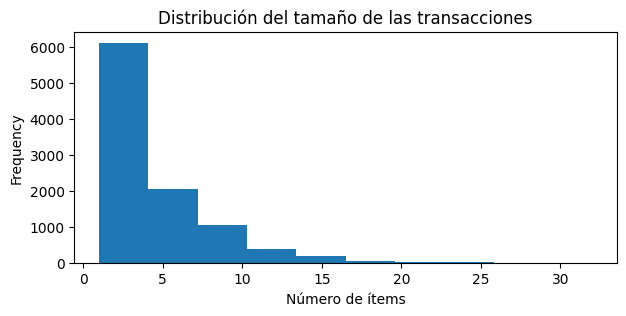

In [7]:
# Distribución del número de ítems por transacción
# ==============================================================================
display(datos.groupby('id_compra')['item'].size().describe(percentiles=[.25, .5, .75, .9]))

fig, ax = plt.subplots(figsize=(7, 3))
datos.groupby('id_compra')['item'].size().plot.hist(ax=ax)
ax.set_title('Distribución del tamaño de las transacciones')
ax.set_xlabel('Número de ítems')

La gran mayoría de clientes compra entre 2 y 6 productos, y el 90% de ellos compra como máximo 9.

El siguiente análisis básico consiste en identificar cuáles son los ítems más frecuentes (los que tienen mayor soporte) dentro del conjunto de todas las transacciones. Se calcula como la fracción de transacciones que contienen dicho ítem respecto al total de todas las transacciones. Esto es distinto de la frecuencia de un ítem respecto al total de ítems, de ahí que la suma de todos los soportes no sea 1.

Para realizar este cálculo se genera una matriz binaria (valores 0/1 o True/False), con una fila por cada transacción, en este caso cada compra, y una columna por cada posible ítem, en este caso productos. La posición de la matriz ( i
 , j
 ) tiene el valor 1 si la transacción  i
  contiene el ítem  j
  y 0 de lo contrario. Existen múltiples formas de construir este tipo de matriz, una de ellas es utilizando la clase TransactionEncoder de la librería mlxtend.

In [8]:
# Codificar las transacciones en forma de matriz binaria
# ==============================================================================
# Crear una lista de listas que contenga los ítems de cada transacción
transacciones = datos.groupby('id_compra')['item'].apply(list).to_list()

# Entrenar el objeto TransactionEncoder y transformar los datos
encoder = TransactionEncoder()
transacciones_encoded = encoder.fit(transacciones).transform(transacciones)
transacciones_encoded = pd.DataFrame(transacciones_encoded, columns=encoder.columns_)
transacciones_encoded.head(3)

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [9]:
# Porcentaje de transacciones en las que aparece cada producto (top 5)
# ==============================================================================
transacciones_encoded.mean(axis = 0).sort_values(ascending = False).head(5)

whole milk          0.255516
other vegetables    0.193493
rolls/buns          0.183935
soda                0.174377
yogurt              0.139502
dtype: float64

Los 5 productos que aparecen con más frecuencia en las cestas de la compra son: whole milk, other vegetables, rolls/buns y soda. Esto no significa necesariamente que sean los productos con mayor volumen de ventas ya que no se está teniendo en cuenta cuántas unidades se venden, sino con qué frecuencia.

Es importante estudiar cómo se distribuye el soporte de los ítems individuales en un conjunto de transacciones antes de identificar itemsets frecuentes o crear reglas de asociación, ya que, dependiendo del caso, tendrá sentido emplear un límite de soporte u otro. Por lo general, cuando el número de posibles ítems es muy grande (varios miles) prácticamente todos los artículos son raros, por lo que los soportes son muy bajos.

Text(0.5, 1.0, 'Distribución del soporte de los ítems')

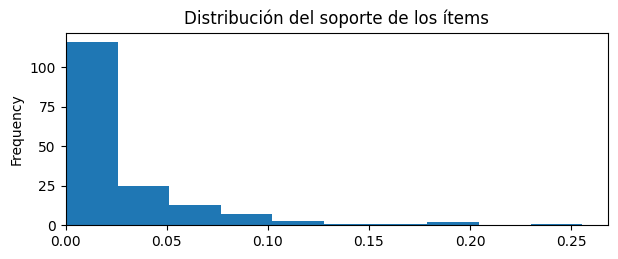

In [10]:
# Distribución del soporte de los items
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
transacciones_encoded.mean(axis = 0).plot.hist(ax = ax)
ax.set_xlim(0, )
ax.set_title('Distribución del soporte de los ítems')

## Itemsets
Las funciones apriori y fpgrowth del paquete mlxtend permiten la identificación de itemsets aplicando cada una el algoritmo que les da nombre.

Ambas funciones requieren que los datos estén almacenados en un data frame de pandas, en formato one hot encoded, también conocido como dummy variables. Se trata de un formato de matriz binaria (valores 0/1 o True/False), con una fila por cada transacción, en este caso cada compra, y una columna por cada posible ítem, en este caso productos. La posición de la matriz ( i
 , j
 ) tiene el valor 1 si la transacción  i
  contiene el ítem  j
  y 0 de lo contrario. Existen múltiples formas de construir este tipo de matriz, una de ellas es utilizando la clase TransactionEncoder de este mismo paquete.

In [11]:
# Codificar las transacciones en forma de matriz binaria
# ==============================================================================
# Crear una lista de listas que contenga los artículos comprados en cada transacción
transacciones = datos.groupby('id_compra')['item'].apply(list).to_list()

# Entrenar el objeto TransactionEncoder y transformar los datos
encoder = TransactionEncoder()
transacciones_encoded = encoder.fit(transacciones).transform(transacciones)
transacciones_encoded = pd.DataFrame(transacciones_encoded, columns=encoder.columns_)
transacciones_encoded.head(3)

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


Una vez que los datos se encuentran en el formato adecuado se ejecuta el algoritmo deseado para la identificación de itemsets frecuentes. Se procede a extraer aquellos itemsets, incluidos los formados por un único ítem, que hayan sido comprados al menos 30 veces. En un caso real, este valor sería excesivamente bajo si se tiene en cuenta la cantidad total de transacciones, sin embargo, se emplea 30 para que en los resultados aparezcan un número suficiente de itemsets y reglas de asociación que permitan mostrar las posibilidades de análisis que ofrece mlxtend.

In [12]:
transacciones_encoded.shape[0]

9835

In [13]:
# Identificación de itemsets frecuentes
# ==============================================================================
soporte = 30 / transacciones_encoded.shape[0]
print(f"Soporte mínimo: {soporte}")
itemsets = apriori(transacciones_encoded, min_support=soporte, use_colnames=True)
itemsets.sort_values(by='support', ascending=False)

Soporte mínimo: 0.003050330452465684


,support,itemsets
133,0.255516,(whole milk)
83,0.193493,(other vegetables)
98,0.183935,(rolls/buns)
111,0.174377,(soda)
134,0.139502,(yogurt)
...,...,...
2173,0.003050,"(pastry, other vegetables, whole milk, root ve..."
2217,0.003050,"(whole milk, whipped/sour cream, rolls/buns, y..."
2186,0.003050,"(sausage, whole milk, rolls/buns, other vegeta..."
2210,0.003050,"(pastry, tropical fruit, whole milk, yogurt)"


In [14]:
# Top 10 itemsets con mayor soporte
# ==============================================================================
itemsets.sort_values(by='support', ascending=False).head(10)

,support,itemsets
133,0.255516,(whole milk)
83,0.193493,(other vegetables)
98,0.183935,(rolls/buns)
111,0.174377,(soda)
134,0.139502,(yogurt)
9,0.110524,(bottled water)
99,0.108998,(root vegetables)
126,0.104931,(tropical fruit)
107,0.098526,(shopping bags)
104,0.093950,(sausage)


## Filtrado de itemsets
Una vez que los itemsets frecuentes han sido identificados, suele ser interesante aplicar determinados filtrados, algunos de los más frecuentes son:

- Itemsets de un tamaño mínimo.

- Itemsets que contienen determinados ítems.

- Itemsets que no contienen un determinado ítem.

In [15]:
# Top 10 itemsets con al menos 2 items, ordenados por soporte
# ==============================================================================
itemsets['n_items'] = itemsets['itemsets'].apply(lambda x: len(x))
itemsets.query('n_items >= 2').sort_values('support', ascending=False).head(10)

,support,itemsets,n_items
1076,0.074835,"(whole milk, other vegetables)",2
1171,0.056634,"(whole milk, rolls/buns)",2
1275,0.056024,"(whole milk, yogurt)",2
1185,0.048907,"(whole milk, root vegetables)",2
1055,0.047382,"(other vegetables, root vegetables)",2
1077,0.043416,"(other vegetables, yogurt)",2
1054,0.042603,"(rolls/buns, other vegetables)",2
1263,0.042298,"(tropical fruit, whole milk)",2
1240,0.040061,"(whole milk, soda)",2
1161,0.038332,"(soda, rolls/buns)",2


In [16]:
# Itemsets frecuentes que contienen el ítem newspapers
# ==============================================================================
mask = itemsets['itemsets'].map(lambda x: 'newspapers' in x)
itemsets.loc[mask].sort_values(by='support', ascending=False)

,support,itemsets,n_items
78,0.079817,(newspapers),1
1017,0.027351,"(newspapers, whole milk)",2
1006,0.019725,"(newspapers, rolls/buns)",2
1002,0.019319,"(newspapers, other vegetables)",2
1018,0.015353,"(newspapers, yogurt)",2
...,...,...,...
896,0.003050,"(hygiene articles, newspapers)",2
957,0.003050,"(newspapers, meat)",2
1876,0.003050,"(sausage, newspapers, rolls/buns)",3
1884,0.003050,"(sausage, newspapers, whole milk)",3


In [17]:
# Itemsets frecuentes que contienen los items, al menos, newspapers y whole milk
# ==============================================================================
items = {'newspapers', 'whole milk'}
mask = itemsets['itemsets'].map(lambda x: x.issuperset(items))
itemsets.loc[mask].sort_values(by='support', ascending=False).reset_index()

,index,support,itemsets,n_items
0,1017,0.027351,"(newspapers, whole milk)",2
1,1872,0.008338,"(newspapers, whole milk, other vegetables)",3
2,1879,0.007626,"(whole milk, newspapers, rolls/buns)",3
3,1889,0.006609,"(newspapers, whole milk, yogurt)",3
4,1882,0.005796,"(newspapers, whole milk, root vegetables)",3
5,1887,0.005084,"(tropical fruit, newspapers, whole milk)",3
6,1885,0.004779,"(whole milk, newspapers, soda)",3
7,1406,0.004067,"(brown bread, newspapers, whole milk)",3
8,1360,0.004067,"(bottled water, newspapers, whole milk)",3
9,1874,0.003864,"(pastry, newspapers, whole milk)",3


Puede observarse que muchos itemsets están a su vez contenidos en itemsets de orden superior, es decir, existen itemsets que son subsets de otros. Para identificar cuáles son, o cuales no lo son, se pueden emplear los métodos issubset() o issuperset().

In [18]:
itemset_a = {'other vegetables', 'whole milk', 'newspapers'}
itemset_b = {'other vegetables', 'whole milk', 'newspapers'}

print(itemset_a.issubset(itemset_b))
print(itemset_b.issuperset(itemset_a))

True
True


## Reglas de asociación
Para crear reglas de asociación se sigue el mismo proceso que para obtener itemsets frecuentes mostrado en el apartado anterior. Una vez obtenidos los itemsets frecuentes, se pasan a la función generate_rules encargada de generar las reglas de asociación y de seleccionar aquellas que alcanzan una valor mínimo de confianza o lift.

In [ ]:
# Identificación de itemsets frecuentes
# ==============================================================================
soporte = 30 / transacciones_encoded.shape[0]
itemsets_frecuentes = apriori(transacciones_encoded, min_support=soporte, use_colnames=True)

# Calcular el número de itemsets (columnas) en itemsets_frecuentes
num_itemsets = itemsets_frecuentes.shape[1]

# Crear reglas de associación (confianza mínima del 70%)
# ==============================================================================
confianza = 0.7 # confianza mínima del 70% para que una regla sea selecionada
reglas = association_rules(itemsets_frecuentes, num_itemsets = num_itemsets, metric="confidence", min_threshold=0.7)
print(f"Número de reglas generadas: {len(reglas)}")
reglas.sort_values(by='confidence').head(5)

Número de reglas generadas: 19


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
12,"(domestic eggs, whipped/sour cream, other vege...",(whole milk),0.005084,0.255516,0.003559,0.700000,2.739554,1.0,0.002260,2.481613,0.638222,0.013845,0.597036,0.356964
14,"(tropical fruit, root vegetables, yogurt)",(whole milk),0.008134,0.255516,0.005694,0.700000,2.739554,1.0,0.003616,2.481613,0.640185,0.022073,0.597036,0.361142
1,"(butter, coffee)",(whole milk),0.004779,0.255516,0.003355,0.702128,2.747881,1.0,0.002134,2.499339,0.639138,0.013059,0.599894,0.357630
4,"(butter, pork)",(whole milk),0.005491,0.255516,0.003864,0.703704,2.754049,1.0,0.002461,2.512633,0.640415,0.015026,0.602011,0.359413
17,"(tropical fruit, other vegetables, citrus frui...",(whole milk),0.004474,0.255516,0.003152,0.704545,2.757344,1.0,0.002009,2.519792,0.640196,0.012272,0.603142,0.358441


Se han identificado un total de 19 reglas con una confianza superior al 70%.

## Filtrado de reglas
Cuando se crean reglas de asociación, puede ser interesante seleccionar únicamente aquellas que contienen un determinado conjunto de ítems. El proceso de filtrado es similar al mostrado para itemsets frecuentes, pero esta vez, puede aplicarse al antecedente, al consecuente o ambos a la vez.

Supóngase que solo son de interés aquellas reglas que muestren productos que se vendan junto con other vegetables. Esto significa que el ítem other vegetables, debe aparecer en el lado derecho de la regla (consequents).

In [20]:
# Seleccionar reglas que tienen "other vegetables" en el consecuente
# ==============================================================================
mask = reglas['consequents'].map(lambda x: 'other vegetables' in x)
reglas.loc[mask]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
10,"(tropical fruit, citrus fruit, root vegetables)",(other vegetables),0.005694,0.193493,0.004474,0.785714,4.060694,1.0,0.003372,3.763701,0.758053,0.022977,0.734304,0.404418
13,"(tropical fruit, whipped/sour cream, root vege...",(other vegetables),0.004575,0.193493,0.003355,0.733333,3.789981,1.0,0.002470,3.024403,0.739530,0.017232,0.669356,0.375337
16,"(tropical fruit, citrus fruit, whole milk, roo...",(other vegetables),0.003559,0.193493,0.003152,0.885714,4.577509,1.0,0.002463,7.056940,0.784332,0.016256,0.858296,0.451002


Hay un total de 3 reglas que tienen el item other vegetables en el consecuente. Los ítems que suelen aparecer en la cesta de la compra junto con other vegetables son:

In [21]:
antecedents = reglas.loc[mask, 'antecedents'].to_list()
set().union(*antecedents)

{'citrus fruit',
 'root vegetables',
 'tropical fruit',
 'whipped/sour cream',
 'whole milk'}

Otro ejemplo de filtrado es encontrar aquellas reglas que contienen un conjunto de ítems teniendo en cuenta tanto el antecedente como el consecuente, por ejemplo, aquellas que contienen al menos los ítems: citrus fruit, root vegetables, tropical fruit, whole milk y other vegetables.

In [22]:
# Crear una columna con los ítems que forman parte del antecedente y el consecuente
# ======================================================================================
reglas['items'] = reglas[['antecedents', 'consequents']].apply(lambda x: set().union(*x), axis=1)
reglas.head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,items
0,"(baking powder, yogurt)",(whole milk),0.004575,0.255516,0.003254,0.711111,2.783039,1.0,0.002085,2.577060,0.643626,0.012668,0.611961,0.361922,"{baking powder, whole milk, yogurt}"
1,"(butter, coffee)",(whole milk),0.004779,0.255516,0.003355,0.702128,2.747881,1.0,0.002134,2.499339,0.639138,0.013059,0.599894,0.357630,"{butter, coffee, whole milk}"
2,"(curd, butter)",(whole milk),0.006812,0.255516,0.004881,0.716418,2.803808,1.0,0.003140,2.625286,0.647755,0.018957,0.619089,0.367759,"{curd, butter, whole milk}"


In [23]:
# Filtrar reglas
# ==============================================================================
seleccion_items = {'citrus fruit', 'root vegetables', 'tropical fruit','whole milk', 'other vegetables'}
mask = reglas['items'].map(lambda x: x.issubset(seleccion_items))
reglas.loc[mask]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,items
10,"(tropical fruit, citrus fruit, root vegetables)",(other vegetables),0.005694,0.193493,0.004474,0.785714,4.060694,1.0,0.003372,3.763701,0.758053,0.022977,0.734304,0.404418,"{tropical fruit, other vegetables, citrus frui..."
16,"(tropical fruit, citrus fruit, whole milk, roo...",(other vegetables),0.003559,0.193493,0.003152,0.885714,4.577509,1.0,0.002463,7.056940,0.784332,0.016256,0.858296,0.451002,"{other vegetables, citrus fruit, tropical frui..."
17,"(tropical fruit, other vegetables, citrus frui...",(whole milk),0.004474,0.255516,0.003152,0.704545,2.757344,1.0,0.002009,2.519792,0.640196,0.012272,0.603142,0.358441,"{whole milk, citrus fruit, tropical fruit, roo..."
